In [93]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torchaudio
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
# https://www.kaggle.com/karthik999/pytorch-human-speech-classification

In [94]:

num_epochs = 50
num_classes = 8
batch_size = 5
learning_rate = 0.000001

sample_rate = 16000
n_mels = 128
n_mfcc = 40 

In [95]:
modality = {'01':'full_av','02':'video_only','03':'audio_only'}
vocal_channel = {'01':'speech','02':'song'}
emotion = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
emotional_intensity = {'01':'normal','02':'strong'}
statement = {'01':'Kids are talking by the door','02':'Dogs are sitting by the door'}
reptition = {'01':'first_repitition','02':'second_repetition'}
def actor_f(num):
    if int(num)%2==0: return('female')
    else: return('male')

In [96]:
actors = sorted(os.listdir('/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24'))
actors.pop()
actors

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23']

In [97]:
audio_file_dict = {}
for actor in actors:
    actor_dir = os.path.join('/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24',actor)
    actor_files = os.listdir(actor_dir)
    actor_dict = [i.replace(".wav","").split("-") for i in actor_files]
    dict_entry = {os.path.join(actor_dir,i):j for i,j in zip(actor_files,actor_dict)}
    audio_file_dict.update(dict_entry)

In [98]:
audio_file_dict = pd.DataFrame(audio_file_dict).T
audio_file_dict.columns = ['modality','vocal_channel','emotion','emotional_intensity','statement','repetition','actor']
audio_file_dict

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-08-02-02-01-01.wav,03,01,08,02,02,01,01
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-08-01-01-01-01.wav,03,01,08,01,01,01,01
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-05-01-02-01-01.wav,03,01,05,01,02,01,01
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-06-01-02-02-01.wav,03,01,06,01,02,02,01
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-06-02-01-02-01.wav,03,01,06,02,01,02,01
...,...,...,...,...,...,...,...
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-03-02-02-02-23.wav,03,01,03,02,02,02,23
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-03-01-01-02-23.wav,03,01,03,01,01,02,23
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-02-02-01-01-23.wav,03,01,02,02,01,01,23
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-02-01-02-01-23.wav,03,01,02,01,02,01,23


In [99]:
audio_file_dict.modality = audio_file_dict.modality.map(modality)
audio_file_dict.vocal_channel = audio_file_dict.vocal_channel.map(vocal_channel)
audio_file_dict.emotion = audio_file_dict.emotion.map(emotion)
audio_file_dict.emotional_intensity = audio_file_dict.emotional_intensity.map(emotional_intensity)
audio_file_dict.statement = audio_file_dict.statement.map(statement)
audio_file_dict.repetition = audio_file_dict.repetition.map(reptition)
audio_file_dict['actor_sex'] = audio_file_dict.actor.apply(actor_f)

In [100]:
audio_file_dict

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,actor_sex
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-08-02-02-01-01.wav,audio_only,speech,surprised,strong,Dogs are sitting by the door,first_repitition,01,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-08-01-01-01-01.wav,audio_only,speech,surprised,normal,Kids are talking by the door,first_repitition,01,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-05-01-02-01-01.wav,audio_only,speech,angry,normal,Dogs are sitting by the door,first_repitition,01,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-06-01-02-02-01.wav,audio_only,speech,fearful,normal,Dogs are sitting by the door,second_repetition,01,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-06-02-01-02-01.wav,audio_only,speech,fearful,strong,Kids are talking by the door,second_repetition,01,male
...,...,...,...,...,...,...,...,...
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-03-02-02-02-23.wav,audio_only,speech,happy,strong,Dogs are sitting by the door,second_repetition,23,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-03-01-01-02-23.wav,audio_only,speech,happy,normal,Kids are talking by the door,second_repetition,23,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-02-02-01-01-23.wav,audio_only,speech,calm,strong,Kids are talking by the door,first_repitition,23,male
/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_23/03-01-02-01-02-01-23.wav,audio_only,speech,calm,normal,Dogs are sitting by the door,first_repitition,23,male


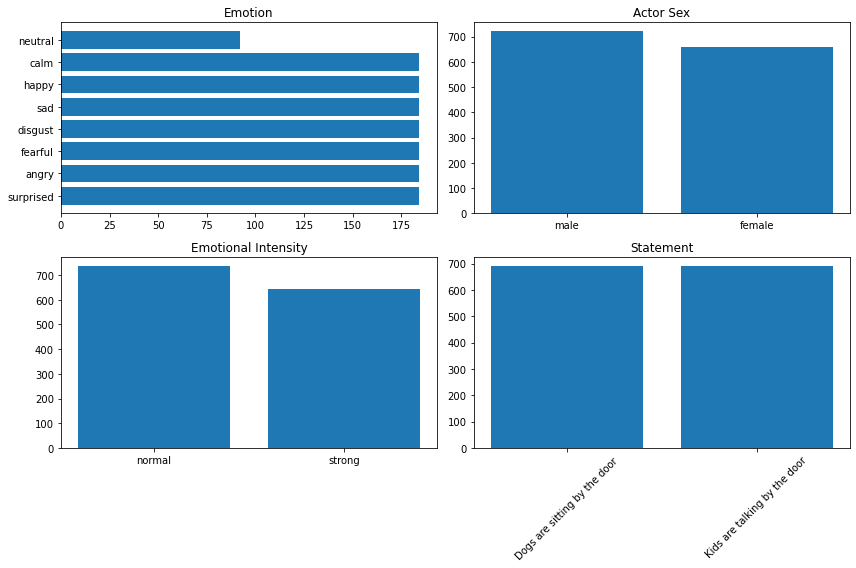

In [101]:
fig, (ax1,ax2) = plt.subplots(2, 2,figsize=(12,8))
ax1[0].barh(y=audio_file_dict.emotion.value_counts().index,width=audio_file_dict.emotion.value_counts().values)
ax1[0].set_title('Emotion')
ax1[1].bar(x=audio_file_dict.actor_sex.value_counts().index,height=audio_file_dict.actor_sex.value_counts().values)
ax1[1].set_title('Actor Sex')
ax2[0].bar(x=audio_file_dict.emotional_intensity.value_counts().index,height=audio_file_dict.emotional_intensity.value_counts().values)
ax2[0].set_title('Emotional Intensity')
ax2[1].bar(x=audio_file_dict.statement.value_counts().index,height=audio_file_dict.statement.value_counts().values)
plt.xticks(rotation=45)
ax2[1].set_title('Statement')
fig.tight_layout() 


In [102]:
sample1, sample_rate1 = torchaudio.load('/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
sample1, sample_rate1

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 48000)

In [103]:
sample2, sample_rate2 = torchaudio.load('/Users/stephen/Emotion_Dectection/data/RAVDESS/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-02-01.wav')
sample2, sample_rate2

(tensor([[ 0.0000e+00,  0.0000e+00, -3.0518e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 48000)

In [104]:
sample1.shape

torch.Size([1, 158558])

In [105]:
sample2.shape

torch.Size([1, 160160])

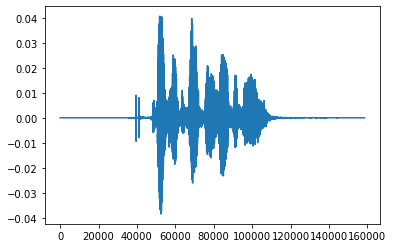

In [106]:
plt.plot(sample1.t().numpy())

In [107]:
audio_file_dict.shape

(1380, 8)

Shape of MFCC: torch.Size([1, 40, 793])


/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/torchaudio/functional/functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


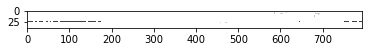

In [108]:
# load all audio files into a python list 

audio_files = []
for i in list(audio_file_dict.index):
    i, _ = torchaudio.load(i)
    audio_files.append(i)


maxlen = 0
minlen = np.Inf
for i in audio_files:
    if i.shape[1]>maxlen:
        maxlen = i.shape[1]
    if i.shape[1]<minlen:
        minlen = i.shape[1]
mfcc = torchaudio.transforms.MFCC()(sample1)

print("Shape of MFCC: {}".format(mfcc.size()))

plt.figure()
plt.imshow(mfcc.log2()[0,:,:].numpy(), cmap='gray')


In [111]:
mfcc_s[0].shape,mfcc_s[1].shape,mfcc_s[2].shape,


(torch.Size([1, 40, 841]), torch.Size([1, 40, 817]), torch.Size([1, 40, 841]))

In [112]:
max_width, max_height = max([i.shape[2] for i in mfcc_s]), max([i.shape[1] for i in mfcc_s])

In [114]:
image_batch = [
    # The needed padding is the difference between the
    # max width/height and the image's actual width/height.
    F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])
    for img in mfcc_s
]

In [115]:
image_batch[0].shape, image_batch[1].shape, image_batch[2].shape,

(torch.Size([1, 40, 1266]),
 torch.Size([1, 40, 1266]),
 torch.Size([1, 40, 1266]))

TypeError: Invalid shape (1266,) for image data

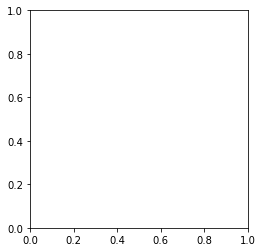

In [120]:
plt.imshow(image_batch[0][0].log2())


In [117]:
image_batch = torch.cat(image_batch,0)

In [118]:
del audio_files, mfcc_s

In [ ]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, audio_file_dict):
        self.audio_file_dict = audio_file_dict.reset_index()

    def __getitem__(self, index):
            img = self.audio_file_dict.reset_index()['index'][index]
            img, _ = torchaudio.load(img)
            img = torch.mean(img, dim=0).unsqueeze(0)
            img = torchaudio.transforms.Spectrogram()(img)
            img = F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])

            label = list(pd.get_dummies(self.audio_file_dict.reset_index().emotion).iloc[index].values)
            label = np.array(label)
            label = torch.from_numpy(label)
            return (img, label)

    def __len__(self):
        count = len(self.audio_file_dict)
        return count

In [ ]:
emo = EmotionDataset(audio_file_dict)

In [ ]:
len(emo)